# Import Libraries

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 

In [225]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [226]:
# read csv file into pandas
df = pd.read_csv("../datasets/question8.csv")
df.head(3)

,question_id,answer,grade
0,8,643م - 709م,2
1,8,القرن السابع,2
2,8,القرن الثالث,0


# EDA

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  86 non-null     int64 
 1   answer       86 non-null     object
 2   grade        86 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


In [228]:
df.groupby('grade').size()

grade
0    29
1    23
2    34
dtype: int64

In [229]:
df.duplicated().sum()

14

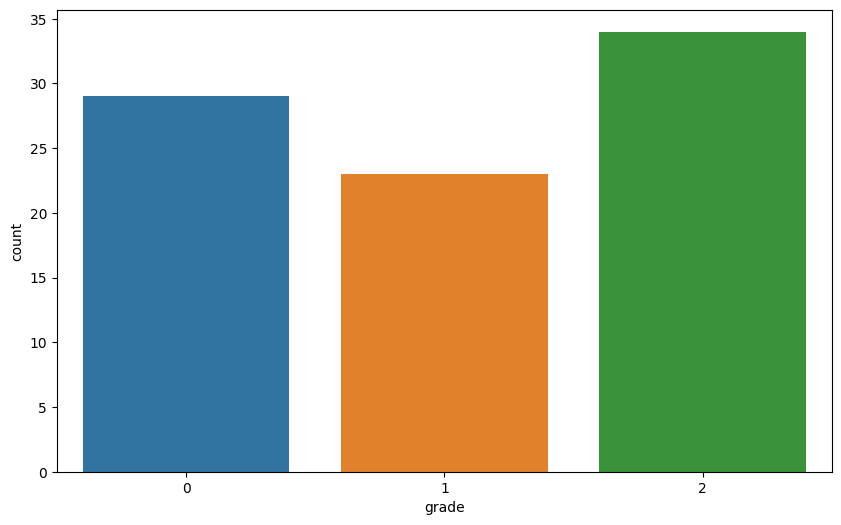

In [230]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

# Data Cleaning

In [231]:
df.drop('question_id', axis=1, inplace=True)

In [232]:
df.dropna(inplace=True)

In [233]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [234]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [235]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [236]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [237]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [238]:
df.head()

,answer,grade,tokens,textvector
0,643م - 709م,2,"[643م, -, 709م]","[0.0004684499, -0.02368987, -0.0091387015, 6.2..."
1,القرن السابع,2,"[القرن, السابع]","[0.0075715748, -0.0037308438, 0.0038619214, 0...."
2,القرن الثالث,0,"[القرن, الثالث]","[-0.0032837826, 0.0006444376, 0.007014363, -0...."
4,القرن الخامس,0,"[القرن, الخامس]","[-0.00875742, 0.0007209232, 0.011001064, 0.018..."
5,من ٦٤٣م الى ٧١٥م,1,"[من, ٦٤٣م, الى, ٧١٥م]","[0.004244124, -0.0048837676, -0.017929532, 0.0..."


# split the data

In [239]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [240]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[ 0.00757157 -0.00373084  0.00386192 ... -0.012996   -0.00061525
   0.01203626]
 [-0.00328378  0.00064444  0.00701436 ... -0.00166782  0.00792422
   0.00257009]
 [-0.00238806  0.0075391   0.00204174 ... -0.00431017  0.0059145
  -0.00344569]
 ...
 [ 0.00964458  0.00733901  0.0012531  ...  0.00889532 -0.00569636
   0.00505331]
 [-0.0103628   0.00476419  0.0081288  ... -0.01450461  0.02237435
  -0.01011875]
 [-0.00670877  0.00522371 -0.00408828 ... -0.00141501  0.00628435
  -0.00084242]]


# build Models 

In [241]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=3)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = KNeighborsClassifier(n_neighbors=3)
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [242]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [243]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [244]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [245]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [246]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [247]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [248]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

# Models Evaluation

In [249]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging
]

In [250]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [251]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.36363636363636365
accuracy SVM RBF :  0.8181818181818182
accuracy Random Forest :  0.7272727272727273
accuracy KNN :  0.6363636363636364
accuracy Naive Bayes :  0.6363636363636364
accuracy ANN :  0.7272727272727273
accuracy Ensemble Learning (Bagging) :  0.6363636363636364


In [252]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.8809523809523809
SVM RBF  Aire sous la courbe ROC: 0.8452380952380952
Random Forest  Aire sous la courbe ROC: 0.8194444444444445
KNN  Aire sous la courbe ROC: 0.6964285714285715
Naive Bayes  Aire sous la courbe ROC: 0.8492063492063492
ANN  Aire sous la courbe ROC: 0.8452380952380952
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 0.7946428571428571


# the best Model

In [253]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [254]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,2,2
1,0,0
2,1,1
3,2,0
4,0,2
5,2,2
6,1,1
7,1,1
8,0,0
9,2,2


# saving the best model

In [280]:
model_path = '../saved_models/model_question8.h5'
with open(model_path, 'wb') as file:
    pickle.dump((model_svm_rbf, model_word2vec), file)

# Test Model

In [279]:
answer = 'hg'
process = txt_preprocess(answer)
txt = get_word_vector(process, model_word2vec)
txt = txt.reshape(1, -1)

i=0
for model in models_names:
    predicted_ques = models[i].predict(txt)[0]
    print(f" {model} :  {predicted_ques}")
    i += 1

 SVM Linear :  2
 SVM RBF :  0
 Random Forest :  0
 KNN :  2
 Naive Bayes :  0
 ANN :  1
 Ensemble Learning (Bagging) :  2
